# In this notebook we're going to play around with the MNIST dataset, which is a basic but quite important dataset when it comes to classification algorithms.

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

# Load fresh MNIST data (don't reuse your broken split)
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target.astype(np.uint8)

In [3]:
print("Total 5s in full dataset:", (y == 5).sum()) # Should be ~6000+

Total 5s in full dataset: 6313


In [4]:
# Stratify on the BINARY TARGET (is_5 vs not_5)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, (y == 5).astype(np.int8)))

X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]


In [5]:
# Creating binary labels
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [6]:
# print("Unique y_train_5:", np.unique(y_train_5))  # MUST show [False True]
# print("Number of 5s:", y_train_5.sum())           # Should be ~5000
# print("Fraction of 5s:", y_train_5.mean())       # ~0.1

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=2000)
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf.score(X_test, y_test_5))

0.8854285714285715


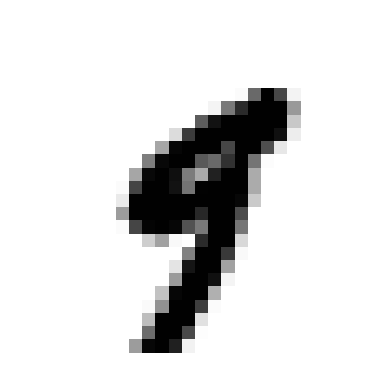

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
sgd_clf.predict([some_digit])

array([False])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

# ===============================================================================================
# The code given below shall give us the same answer. Though, the outputs are gonna vary a little.
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

0.9617506830235174
0.9683398510740879
0.9573020465016607


array([0.96271495, 0.95885788, 0.96394514])

In [11]:
# Let's look at a classifier which classifies every image as a not 5 class.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91101945, 0.91139444, 0.90705025])

In [12]:
# Confusion Matrix

# cross_val_predict() function
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[50142,   808],
       [ 1329,  3721]])

In [13]:
# Computing precision and recall score.
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred),recall_score(y_train_5, y_train_pred)

(0.8215941708986532, 0.7368316831683168)

In [14]:
# f1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7769078191878067

In [15]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-6033.83173289])

In [16]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [17]:
threshold = -200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

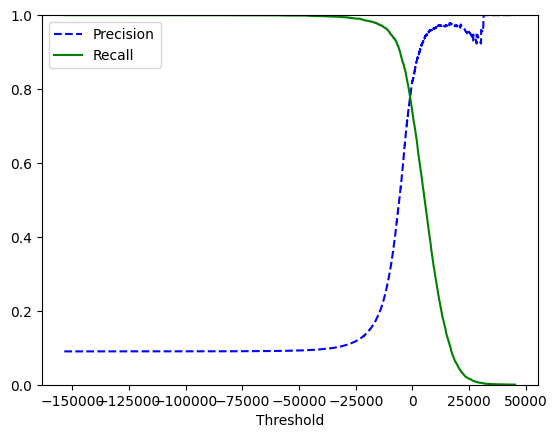

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [21]:
y_train_pred_90 = (y_scores>70000)

precision_score(y_train_5, y_train_pred_90, zero_division=0.0), recall_score(y_train_5, y_train_pred_90, zero_division=0.0)

(0.0, 0.0)

In [22]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

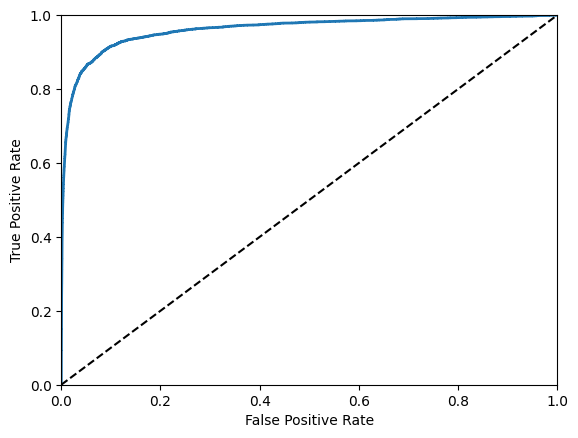

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9613458311876328

In [25]:
# Using RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [26]:
y_scores_forest = y_probas_forest[:, 1] # sore = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

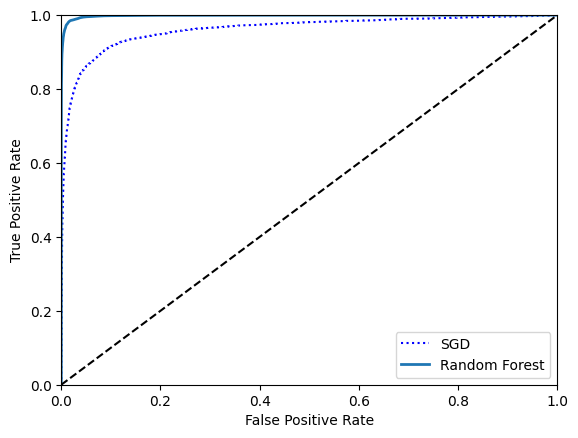

In [27]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985535712550647

# Multiclass Classification

In [29]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

In [30]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-32850.52578669, -25966.83141027, -20232.97485715,
         -4975.50705374,    168.58888841,  -5047.89504403,
        -35177.697471  ,  -6267.19080038,  -9503.61358109,
         -1036.35249756]])

In [31]:
np.argmax(some_digit_scores)

np.int64(4)

In [32]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [33]:
sgd_clf.classes_[5]

np.uint8(5)

In [34]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4], dtype=uint8)

In [35]:
len(ovo_clf.estimators_)

45

In [36]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=uint8)

In [37]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.  , 0.09, 0.01, 0.  , 0.03, 0.  , 0.87]])

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88509134, 0.86071677, 0.87876353])

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90528741, 0.90126962, 0.90067502])

# Error Analysis

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5240,    0,   15,    8,    7,   37,   30,    5,  179,    1],
       [   1, 6022,   44,   18,    3,   42,    6,    7,  173,   11],
       [  24,   21, 4926,   70,   76,   24,   62,   33,  313,   15],
       [  23,   23,  106, 4917,    1,  196,   21,   42,  322,   62],
       [   8,   13,   48,   11, 4884,   11,   34,   18,  257,  147],
       [  26,   16,   29,  167,   53, 4192,   79,   22,  402,   64],
       [  29,   20,   48,    0,   41,   96, 5153,    5,  116,    2],
       [  26,   13,   56,   26,   45,   12,    2, 5349,  145,  194],
       [  19,   60,   42,   85,    5,  119,   34,    8, 4999,   47],
       [  20,   21,   25,   65,  134,   35,    1,  162,  281, 4853]])

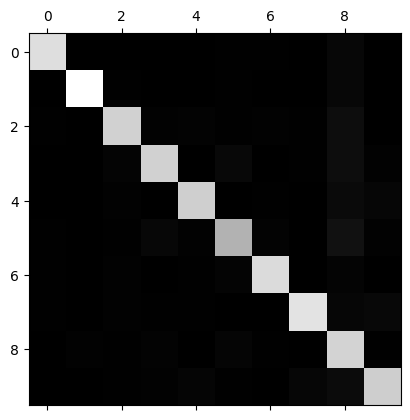

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [45]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

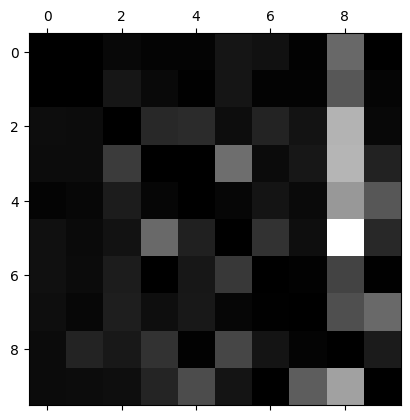

In [48]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [55]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

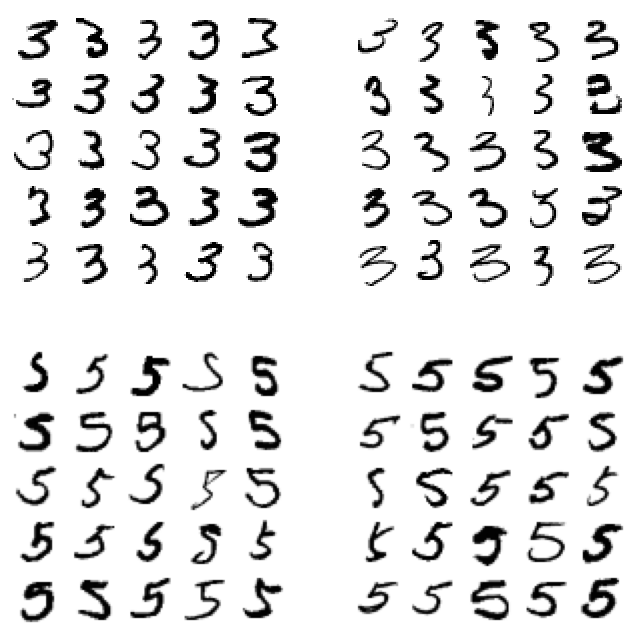

In [58]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

# Multilabel Classification

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [60]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [61]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9673540399899961

In [62]:
f1_score(y_train, y_train_knn_pred, average="weighted")

0.9674591092600645

# Multioutput Classification

In [63]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

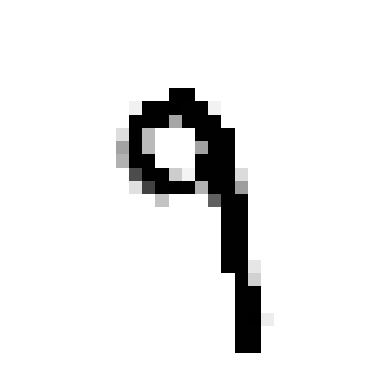

In [67]:
some_index = 3602
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)

# Exercise